# AMR Scaling

This notebook aims at understanding how "fast" (ideally) an AMR simulation is compared to a non-AMR simulation that would evolve a system resolved with the finest resolution of the AMR one, up to the same final time.


We assume a patch hierarchy if $\Gamma$ levels. We assume an isotropic refinement ratio $f=2$ in all directions of the $D$ dimensions. We assume the CFL condition is $\Delta t \sim \Delta x^2$, meaning each refinement $r$ comes with $2^2$ more time steps to evolve.

We name the "equivalent simulation" the simulation without refinement which uniform resolution equals that of the finest level of the AMR simulation.


Given a reference simulation made of N computational cells in $D$ dimensions. The equivalent simulation of an AMR simulation with $\Gamma$ levels has a total of :

$$N_{equiv}= 2^{D(\Gamma-1)}N$$

cells, since there are $\Gamma-1$ refinements of $2^D$ times the N cells.


Moreover, to respect the CFL condition, that equivalent simulation needs to evolve $2^{2(\Gamma-1)}$ more steps.



The AMR simulation on the other hands, evolve all equations on all levels. Let's assume a ratio $\alpha_0$ of the coarsest level $L_0$ is refined by the first refined level $L_1$. This means that the total number of cell of that 2-levels AMR simulation, given N cells on the reference simulation, is : 

$$N_{AMR} = N + \alpha_0 N$$ 


If $L_0$ is evolved with the time step $\Delta t$ the fine level $L_1$ is however evolved with $\Delta t/4$. Said differently $L_1$ evolves $2^{2*1}$ more steps than $L_0$.


If we now add a level $L_2$ which overlaps 0.5% of $L_1$, it covers $0.5\alpha_0$ of $L_0$. This hierarchy as a total number of cells equal to : 


$$N_{AMR} = N + \alpha_0N + \frac{\alpha_0}{2}N$$


Here, $L_1$ evolves $2^2$ more cycles than $L_0$ and $L_2$ evolves $2^4=2^{2*2}$ more cycles than $L_0$.


A patch hierarchy with $\Gamma$ levels therefore has a total number of cells equal to : 


$$N_{AMR} = N\left(1 + \sum_{\gamma=1}^{\Gamma-1} \frac{\alpha_0}{2^{\gamma-1}} 2^{\gamma D}\right)$$


Each level $\gamma$ evolves $2^{2\gamma}$ times more cycles than $L_0$.



If we now define the computational cost $C$ of a simulation as the product of the number of cells and the number of cycles, the equivalent simulation of the $\Gamma$-levels AMR hierarchy costs:


$$C_{equiv} =2^{(\Gamma-1)(D+2)}N $$


The cost of the AMR simulation is :


$$C_{AMR} = N\left(1 + \sum_{\gamma=1}^{\Gamma-1} \frac{\alpha_0}{2^{\gamma-1}} 2^{\gamma(D+2)}\right)$$



We can now define the Benefit $B$ of running the AMR simulation instead of the equivalent simulation by dividing the respective costs:






$$B\left(\Gamma, \alpha_0, D\right) = \frac{1 + \sum_{\gamma=1}^{\Gamma-1} \frac{\alpha_0}{2^{\gamma-1}} 2^{\gamma(D+2)}}{=2^{(\Gamma-1)(D+2)}}$$


Let us assume $\alpha_0=0.1$, meaning that 10% of the simulation is refined. We can now assume, the benefit of running the AMR simulation as a function of the total number of levels $\Gamma$ for 1D, 2D and 3D runs.

In [20]:
def cost(G, alpha, dim=1, temporal=True):
    twos = np.ones(G-1)+1
    p = np.arange(G-1)+1
    if temporal:
        off=2
    else:
        off = 0
    g  = np.copy(p)
    p  = g*(dim+off)
    return (1 + np.sum(np.power(twos, p)*alpha/np.power(2, g-1)))/(2**((dim+off)*(G-1)))

In [21]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'B')

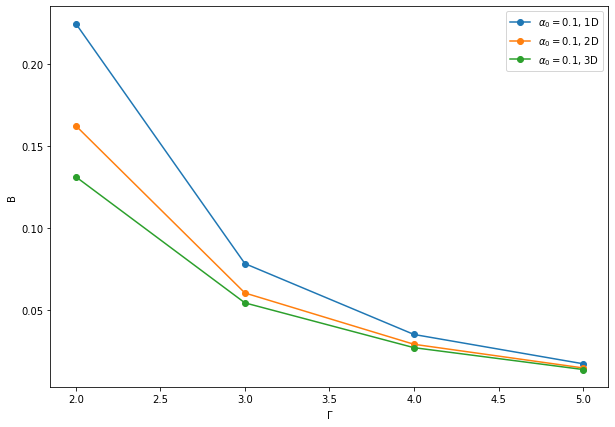

In [29]:
#plot
fig,ax = plt.subplots(figsize=(10,7))
nlev = np.arange(4)+2
alphas=np.arange(0.,1,0.1)
for a in alphas[1:2]:
    for d in np.arange(3)+1:
        c = np.asarray([cost(g, a, dim=d, temporal=True) for g in nlev])
        ax.plot(nlev, c, marker='o', label=r"$\alpha_0={}$, {}D".format(a, d))
ax.legend()
ax.set_xlabel(r"$\Gamma$")
ax.set_ylabel("B")

This shows that the benefit of AMR is stronger in 3D than in 2D, which is itself stronger than in 1D. This is expected since the refinement is isotropic and equal to 2. This also shows that it is increasingly beneficial to run AMR simulations as the total number of level increases. This comes from two reasons : first for a small $\alpha_0$ the equivalent simulation always has substantially more cells than the AMR one, second, the equivalent simulation runs subtantially more steps than the AMR one, due to the refine time stepping.


as a check of the equation, we plot below the benefit of an AMR simulation for which $\alpha_0=0.5$ without accounting for the time refinement, i.e. the ratio of the number of cells between the AMR and the equivalent simulation.





Text(0, 0.5, 'B')

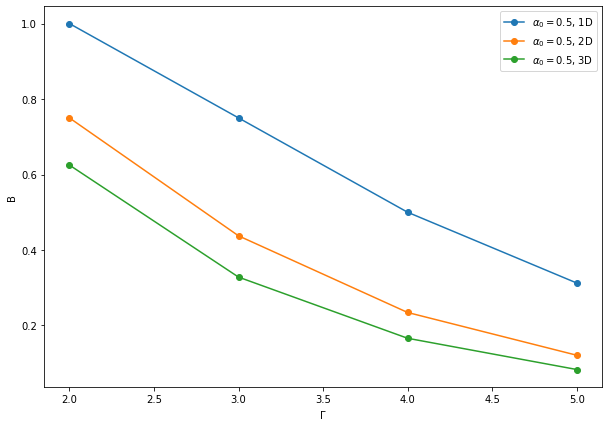

In [42]:
#plot
fig,ax = plt.subplots(figsize=(10,7))
nlev = np.arange(4)+2
alphas=np.arange(0.,1,0.1)
for a in alphas[5:6]:
    for d in np.arange(3)+1:
        c = np.asarray([cost(g, a, dim=d, temporal=False) for g in nlev])
        ax.plot(nlev, c, marker='o', label=r"$\alpha_0={}$, {}D".format(a, d))
ax.legend()
ax.set_xlabel(r"$\Gamma$")
ax.set_ylabel("B")


As expected, for the 1D case, the 2-levels simulations has as many cells at the equivalent simulation. In 2D and 3D however, the isotropic refinement already makes the AMR beneficial.


PHARE will never really have a mesh size greater than 1, because it still needs to resolve the ion larmor radius (assumed to be 1, i.e. for a $\beta=1$ simulation). And it is probably superfluous to go beyond a mesh size of 0.1. This means that PHARE will probably never evolve hierarchies deeper than 4 levels.

If we now take a 4-levels hierarchy, the plot below shows how the benefits increases as the portion of the coarsest domain is refined (up to level 3)

Text(0, 0.5, 'B')

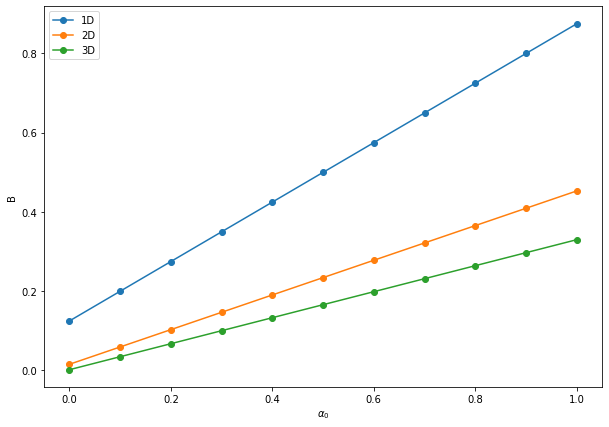

In [58]:
#plot
fig,ax = plt.subplots(figsize=(10,7))
alphas=np.arange(0.,1.1,0.1)
for d in np.arange(3)+1:
    c = np.asarray([cost(4, a, dim=d, temporal=False) for a in alphas])
    ax.plot(alphas, c, marker='o', label=r"{}D".format(d))
ax.legend()
ax.set_xlabel(r"$\alpha_0$")
ax.set_ylabel("B")
